In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
)
from ripple_heterogeneity.replay import replay_run, influence_of_layer_bias_on_replay
from ripple_heterogeneity.readout import readout_explained_var
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nelpy as nel
import nelpy.plotting as npl
from matplotlib.ticker import AutoMinorLocator
from sklearn.cluster import KMeans
import os
from scipy import stats

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")

region_df = pd.DataFrame()
for basepath in df.basepath:
    brainRegions = loading.load_brain_regions(basepath)
    temp_df = pd.DataFrame()
    temp_df["brainRegions"] = brainRegions.keys()
    temp_df["basepath"] = basepath
    region_df = pd.concat([region_df, temp_df], ignore_index=True)

sessions = region_df[region_df.brainRegions.str.contains("PFC|EC1|EC2|EC3|EC4|EC5|MEC")]
df_sessions = pd.DataFrame()
df_sessions["basepath"] = sessions.basepath.unique()
df_sessions

,basepath
0,Z:\Data\AYAold\AYA7\day19
1,Z:\Data\AYAold\AYA7\day20
2,Z:\Data\AYAold\AYA7\day24
3,Z:\Data\AYAold\AYA7\day25
4,Z:\Data\AYAold\AYA7\day27
...,...
105,Z:\Data\FujisawaS\EE\EE0705fm
106,Z:\Data\FujisawaS\EE\EE0706fm
107,Z:\Data\FujisawaS\EE\EE0708fm
108,Z:\Data\HMC1\day12


In [8]:
from pyinform import conditional_entropy,entropy_rate,mutual_info,transfer_entropy

# xs = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1]
# ys = [0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1]
# conditional_entropy(xs,ys) 

In [5]:
basepath = r"Z:\Data\HMC1\day13"
st,cm = loading.load_spikes(basepath,putativeCellType="Pyr",brainRegion="PFC|CA1|MEC")

In [6]:
ripples_df = loading.load_ripples_events(basepath)
ripples = nel.EpochArray(np.array([ripples_df.start,ripples_df.stop]).T).expand(0.05,direction="start").expand(0.2,direction="stop")
# ripples.expand(0.05,direction="start")

ripple_mat = functions.get_participation(st.data,ripples.starts,ripples.stops,par_type="firing_rate")
ripple_mat.shape

(319, 7471)

In [52]:
import itertools


def pairwise_info(X):
    """
    Compute the pairwise mutual information between all pairs of variables in X.
    inputs:
        X: a numpy array of shape (n,d) where d is the number of samples and n is the number of variables
    outputs:
        a numpy array of shape (n,n) where the (i,j) entry is the mutual information between the ith and jth variables

    """
    x = np.arange(0, X.shape[0])
    pairs = np.array(list(itertools.combinations(x, 2)))
    mi = []
    ce = []
    for pair in pairs:
        mi.append(mutual_info(X[pair[0], :], X[pair[1], :]))
        ce.append(conditional_entropy(X[pair[0], :], X[pair[1], :]))
    return np.hstack(mi),np.hstack(ce), pairs

def pairwise_conditional_entropy(X):
    """
    Compute the pairwise mutual information between all pairs of variables in X.
    inputs:
        X: a numpy array of shape (n,d) where d is the number of samples and n is the number of variables
    outputs:
        a numpy array of shape (n,n) where the (i,j) entry is the mutual information between the ith and jth variables

    """
    x = np.arange(0, X.shape[0])
    pairs = np.array(list(itertools.product(x,repeat=2)))
    ce = []
    for pair in pairs:
        ce.append(conditional_entropy(X[pair[0], :], X[pair[1], :]))
    return np.hstack(ce), pairs

mi, ce, pairs_mi= pairwise_info(ripple_mat)
ce, pairs_ce = pairwise_conditional_entropy(ripple_mat)


In [63]:
def make_df(ce,pairs,cm,y_label=None):
    deep_pfc = (
        np.in1d(pairs[:, 0], np.where(cm.brainRegion.str.contains("CA1") & cm.deepSuperficial.str.contains("Deep"))[0])
        & np.in1d(pairs[:, 1], np.where(cm.brainRegion.str.contains("PFC"))[0])
    ) | (
        np.in1d(pairs[:, 0], np.where(cm.brainRegion.str.contains("PFC"))[0])
        & np.in1d(pairs[:, 1], np.where(cm.brainRegion.str.contains("CA1") & cm.deepSuperficial.str.contains("Deep"))[0])
    )

    deep_mec = (
        np.in1d(pairs[:, 0], np.where(cm.brainRegion.str.contains("CA1") & cm.deepSuperficial.str.contains("Deep"))[0])
        & np.in1d(pairs[:, 1], np.where(cm.brainRegion.str.contains("MEC"))[0])
    ) | (
        np.in1d(pairs[:, 0], np.where(cm.brainRegion.str.contains("MEC"))[0])
        & np.in1d(pairs[:, 1], np.where(cm.brainRegion.str.contains("CA1") & cm.deepSuperficial.str.contains("Deep"))[0])
    )

    sup_pfc = (
        np.in1d(pairs[:, 0], np.where(cm.brainRegion.str.contains("CA1") & cm.deepSuperficial.str.contains("Superficial"))[0])
        & np.in1d(pairs[:, 1], np.where(cm.brainRegion.str.contains("PFC"))[0])
    ) | (
        np.in1d(pairs[:, 0], np.where(cm.brainRegion.str.contains("PFC"))[0])
        & np.in1d(pairs[:, 1], np.where(cm.brainRegion.str.contains("CA1") & cm.deepSuperficial.str.contains("Superficial"))[0])
    )

    sup_mec = (
        np.in1d(pairs[:, 0], np.where(cm.brainRegion.str.contains("CA1") & cm.deepSuperficial.str.contains("Superficial"))[0])
        & np.in1d(pairs[:, 1], np.where(cm.brainRegion.str.contains("MEC"))[0])
    ) | (
        np.in1d(pairs[:, 0], np.where(cm.brainRegion.str.contains("MEC"))[0])
        & np.in1d(pairs[:, 1], np.where(cm.brainRegion.str.contains("CA1") & cm.deepSuperficial.str.contains("Superficial"))[0])
    )
    df = pd.DataFrame()

    df[y_label] = np.hstack([ce[deep_pfc], ce[deep_mec], ce[sup_pfc], ce[sup_mec]])
    df["label"] = np.hstack(
        [
            ["deep_pfc"] * len(ce[deep_pfc]),
            ["deep_mec"] * len(ce[deep_mec]),
            ["sup_pfc"] * len(ce[sup_pfc]),
            ["sup_mec"] * len(ce[sup_mec]),
        ]
    )
    df["reference"] = np.hstack(
        [
            cm.brainRegion.iloc[pairs[deep_pfc, 0]],
            cm.brainRegion.iloc[pairs[deep_mec, 0]],
            cm.brainRegion.iloc[pairs[sup_pfc, 0]],
            cm.brainRegion.iloc[pairs[sup_mec, 0]],
        ]
    )

    df["target"] = np.hstack(
        [
            cm.brainRegion.iloc[pairs[deep_pfc, 1]],
            cm.brainRegion.iloc[pairs[deep_mec, 1]],
            cm.brainRegion.iloc[pairs[sup_pfc, 1]],
            cm.brainRegion.iloc[pairs[sup_mec, 1]],
        ]
    )
    df["reference_uid"] = np.hstack(
        [
            cm.UID.iloc[pairs[deep_pfc, 0]],
            cm.UID.iloc[pairs[deep_mec, 0]],
            cm.UID.iloc[pairs[sup_pfc, 0]],
            cm.UID.iloc[pairs[sup_mec, 0]],
        ]
    )

    df["target_uid"] = np.hstack(
        [
            cm.UID.iloc[pairs[deep_pfc, 1]],
            cm.UID.iloc[pairs[deep_mec, 1]],
            cm.UID.iloc[pairs[sup_pfc, 1]],
            cm.UID.iloc[pairs[sup_mec, 1]],
        ]
    )
    return df


In [64]:
conditional_entropy_df = make_df(ce,pairs_ce,cm,"conditional_entropy")
conditional_entropy_df.loc[~conditional_entropy_df.reference.str.contains("CA1"),"conditional_entropy"] = np.nan
conditional_entropy_df.dropna(inplace=True)
conditional_entropy_df

,conditional_entropy,label,reference,target,reference_uid,target_uid
11205,1.360668,deep_pfc,CA1so,PFC,272,1
11206,0.994142,deep_pfc,CA1so,PFC,272,2
11207,0.942368,deep_pfc,CA1so,PFC,272,3
11208,1.533153,deep_pfc,CA1so,PFC,272,4
11209,1.537234,deep_pfc,CA1so,PFC,272,6
...,...,...,...,...,...,...
45517,0.310773,sup_mec,CA1sr,MEC,420,540
45518,0.800484,sup_mec,CA1sr,MEC,420,541
45519,0.641952,sup_mec,CA1sr,MEC,420,542
45520,1.954237,sup_mec,CA1sr,MEC,420,546


In [65]:
mutual_info_df = make_df(mi,pairs_mi,cm,"mutual_info")

mutual_info_df

,mutual_info,label,reference,target,reference_uid,target_uid
0,0.067176,deep_pfc,PFC,CA1so,1,272
1,0.078890,deep_pfc,PFC,CA1so,1,274
2,0.084916,deep_pfc,PFC,CA1so,1,279
3,0.043270,deep_pfc,PFC,CA1so,1,281
4,0.056667,deep_pfc,PFC,CA1so,1,283
...,...,...,...,...,...,...
23953,0.026522,sup_mec,CA1sr,MEC,420,540
23954,0.070829,sup_mec,CA1sr,MEC,420,541
23955,0.057868,sup_mec,CA1sr,MEC,420,542
23956,0.209924,sup_mec,CA1sr,MEC,420,546


In [81]:
test_df = pd.merge(mutual_info_df, conditional_entropy_df, on=["reference_uid", "target_uid","reference","target"],how="right")
test_df

,mutual_info,label_x,reference,target,reference_uid,target_uid,conditional_entropy,label_y
0,NaN,NaN,CA1so,PFC,272,1,1.360668,deep_pfc
1,NaN,NaN,CA1so,PFC,272,2,0.994142,deep_pfc
2,NaN,NaN,CA1so,PFC,272,3,0.942368,deep_pfc
3,NaN,NaN,CA1so,PFC,272,4,1.533153,deep_pfc
4,NaN,NaN,CA1so,PFC,272,6,1.537234,deep_pfc
...,...,...,...,...,...,...,...,...
23953,0.026522,sup_mec,CA1sr,MEC,420,540,0.310773,sup_mec
23954,0.070829,sup_mec,CA1sr,MEC,420,541,0.800484,sup_mec
23955,0.057868,sup_mec,CA1sr,MEC,420,542,0.641952,sup_mec
23956,0.209924,sup_mec,CA1sr,MEC,420,546,1.954237,sup_mec


<AxesSubplot:xlabel='label_y', ylabel='conditional_entropy'>

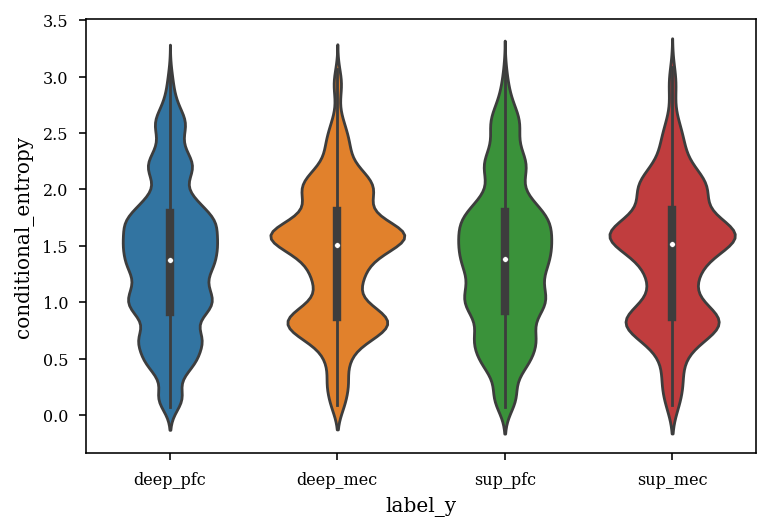

In [80]:
sns.violinplot(x="label_y", y="conditional_entropy", data=test_df)


<AxesSubplot:xlabel='label', ylabel='conditional_entropy'>

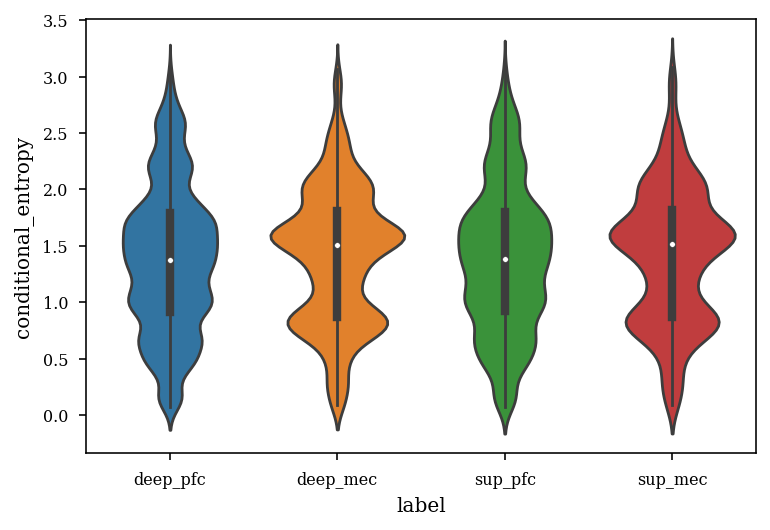

In [54]:
sns.violinplot(x="label", y="conditional_entropy", data=df)

In [38]:
deep_pfc = idx = (
    np.in1d(pairs[:, 0], np.where(cm.brainRegion.str.contains("CA1") & cm.deepSuperficial.str.contains("Deep"))[0])
    & np.in1d(pairs[:, 1], np.where(cm.brainRegion.str.contains("PFC"))[0])
) | (
    np.in1d(pairs[:, 0], np.where(cm.brainRegion.str.contains("PFC"))[0])
    & np.in1d(pairs[:, 1], np.where(cm.brainRegion.str.contains("CA1") & cm.deepSuperficial.str.contains("Deep"))[0])
)

deep_mec = idx = (
    np.in1d(pairs[:, 0], np.where(cm.brainRegion.str.contains("CA1") & cm.deepSuperficial.str.contains("Deep"))[0])
    & np.in1d(pairs[:, 1], np.where(cm.brainRegion.str.contains("MEC"))[0])
) | (
    np.in1d(pairs[:, 0], np.where(cm.brainRegion.str.contains("MEC"))[0])
    & np.in1d(pairs[:, 1], np.where(cm.brainRegion.str.contains("CA1") & cm.deepSuperficial.str.contains("Deep"))[0])
)

sup_pfc = idx = (
    np.in1d(pairs[:, 0], np.where(cm.brainRegion.str.contains("CA1") & cm.deepSuperficial.str.contains("Superficial"))[0])
    & np.in1d(pairs[:, 1], np.where(cm.brainRegion.str.contains("PFC"))[0])
) | (
    np.in1d(pairs[:, 0], np.where(cm.brainRegion.str.contains("PFC"))[0])
    & np.in1d(pairs[:, 1], np.where(cm.brainRegion.str.contains("CA1") & cm.deepSuperficial.str.contains("Superficial"))[0])
)

sup_mec = idx = (
    np.in1d(pairs[:, 0], np.where(cm.brainRegion.str.contains("CA1") & cm.deepSuperficial.str.contains("Superficial"))[0])
    & np.in1d(pairs[:, 1], np.where(cm.brainRegion.str.contains("MEC"))[0])
) | (
    np.in1d(pairs[:, 0], np.where(cm.brainRegion.str.contains("MEC"))[0])
    & np.in1d(pairs[:, 1], np.where(cm.brainRegion.str.contains("CA1") & cm.deepSuperficial.str.contains("Superficial"))[0])
)

In [12]:
df = pd.DataFrame()
df["mutual_info"] = np.hstack([mi[deep_pfc], mi[deep_mec], mi[sup_pfc], mi[sup_mec]])
df["conditional_entropy"] = np.hstack([ce[deep_pfc], ce[deep_mec], ce[sup_pfc], ce[sup_mec]])
df["label"] = np.hstack(
    [
        ["deep_pfc"] * len(mi[deep_pfc]),
        ["deep_mec"] * len(mi[deep_mec]),
        ["sup_pfc"] * len(mi[sup_pfc]),
        ["sup_mec"] * len(mi[sup_mec]),
    ]
)
df["reference"] = np.hstack(
    [
        cm.brainRegion.iloc[pairs[deep_pfc, 0]],
        cm.brainRegion.iloc[pairs[deep_mec, 0]],
        cm.brainRegion.iloc[pairs[sup_pfc, 0]],
        cm.brainRegion.iloc[pairs[sup_mec, 0]],
    ]
)

df["target"] = np.hstack(
    [
        cm.brainRegion.iloc[pairs[deep_pfc, 1]],
        cm.brainRegion.iloc[pairs[deep_mec, 1]],
        cm.brainRegion.iloc[pairs[sup_pfc, 1]],
        cm.brainRegion.iloc[pairs[sup_mec, 1]],
    ]
)

df["reference_uid"] = np.hstack(
    [
        cm.UID.iloc[pairs[deep_pfc, 0]],
        cm.UID.iloc[pairs[deep_mec, 0]],
        cm.UID.iloc[pairs[sup_pfc, 0]],
        cm.UID.iloc[pairs[sup_mec, 0]],
    ]
)

df["target_uid"] = np.hstack(
    [
        cm.UID.iloc[pairs[deep_pfc, 1]],
        cm.UID.iloc[pairs[deep_mec, 1]],
        cm.UID.iloc[pairs[sup_pfc, 1]],
        cm.UID.iloc[pairs[sup_mec, 1]],
    ]
)
df


,mutual_info,conditional_entropy,label,reference,target,reference_uid,target_uid
0,0.067176,1.429065,deep_pfc,PFC,CA1so,1,272
1,0.078890,1.717974,deep_pfc,PFC,CA1so,1,274
2,0.084916,1.647071,deep_pfc,PFC,CA1so,1,279
3,0.043270,1.159592,deep_pfc,PFC,CA1so,1,281
4,0.056667,1.454070,deep_pfc,PFC,CA1so,1,283
...,...,...,...,...,...,...,...
23953,0.026522,0.310773,sup_mec,CA1sr,MEC,420,540
23954,0.070829,0.800484,sup_mec,CA1sr,MEC,420,541
23955,0.057868,0.641952,sup_mec,CA1sr,MEC,420,542
23956,0.209924,1.954237,sup_mec,CA1sr,MEC,420,546


In [18]:
df.loc[~df.reference.str.contains("CA1"),"conditional_entropy"] = np.nan

<AxesSubplot:xlabel='mutual_info', ylabel='conditional_entropy'>

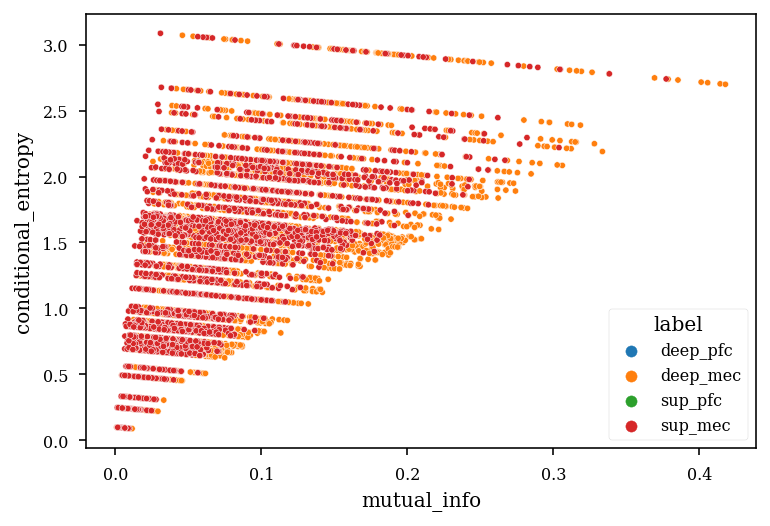

In [19]:
sns.scatterplot(x="mutual_info", y="conditional_entropy", hue="label", data=df,s=10)

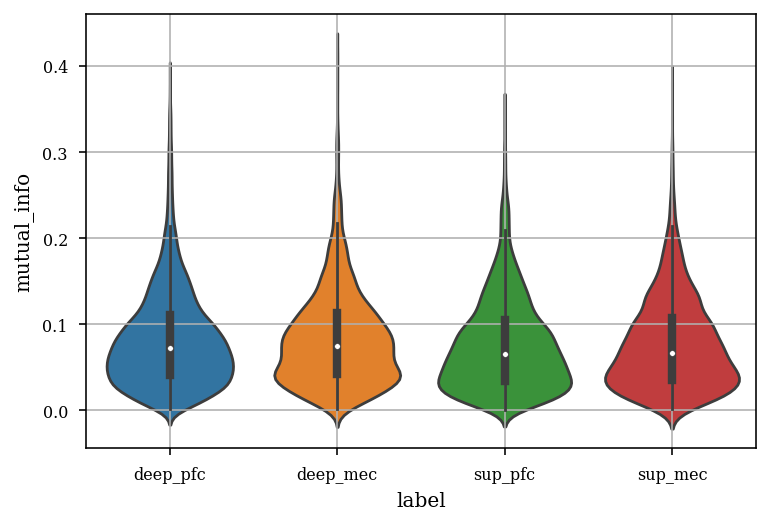

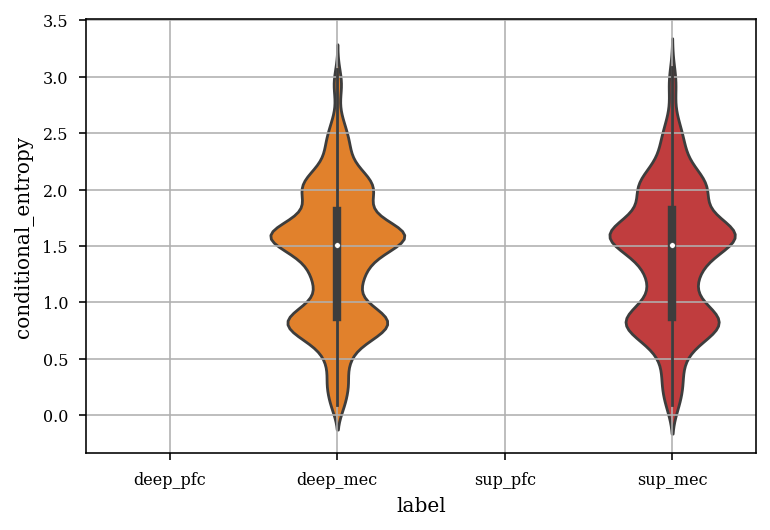

In [20]:
sns.violinplot(x="label", y="mutual_info", data=df)
# sns.stripplot(x="label", y="mi", data=df, color="black", size=1)
# plt.yscale("log")
plt.grid()
plt.show()

sns.violinplot(x="label", y="conditional_entropy", data=df)

plt.grid()
plt.show()